# L26: Name generation with GPT-2 (custom hyperparameters)

Steps:
1. Install the dependencies
2. Load the imports
3. Define the model and tokenizer
4. Tokenize all the names
5. Prepare the data for training
6. Set up the training arguments (change learning rate and others)
7. Train the model (plot the loss curve)
8. Generate new names (change temperature and others)


In [ ]:
# !pip install transformers datasets accelerate

In [1]:
# set up the imports
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForCausalLM
from transformers import Trainer, TrainingArguments, pipeline
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
dataset = load_dataset('text', data_files='names.txt')

# look at first item
dataset['train'][0]

{'text': 'emma'}

In [3]:
# choose model and tokenizer
model_name = 'distilgpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name, pad_token=' ')

In [4]:
# define a function to tokenize a name
def tokenize_name(name):
    tokens = tokenizer(
        name['text'] + tokenizer.eos_token,
    )

    return tokens

tokenized_name = tokenize_name({'text' : 'garrett'})
token_id_list = tokenized_name['input_ids']
token_list = tokenizer.convert_ids_to_tokens(token_id_list)

token_list

['gar', 'rett', '<|endoftext|>']

In [5]:
dataset['train']

Dataset({
    features: ['text'],
    num_rows: 32033
})

In [6]:
tokenized_names = dataset['train'].map(
    tokenize_name,
    batched=False,
    remove_columns=['text']
)

tokenized_names

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 32033
})

In [7]:
# prepare dataset for training
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# data_collator

Embedding(50258, 768)

In [17]:
# set up training arguments
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir='name-gpt',
    per_device_train_batch_size=8,
    max_steps=100,
    fp16=False,
    bf16=False,
    logging_steps=10, # record the loss every 10 iterations 
    learning_rate=5e-3, # 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_names,
    data_collator=data_collator
)

trainer.train()

Step,Training Loss
10,5.818800
20,3.915900
30,3.851600
40,3.922400
50,3.457100
60,3.652000
70,3.377700
80,3.327900
90,3.261900
100,3.329700


TrainOutput(global_step=100, training_loss=3.7914934158325195, metrics={'train_runtime': 86.2896, 'train_samples_per_second': 9.271, 'train_steps_per_second': 1.159, 'total_flos': 926786912256.0, 'train_loss': 3.7914934158325195, 'epoch': 0.024968789013732832})

In [18]:
# filter out logs a loss value
logs_fast_learning = [entry for entry in trainer.state.log_history if 'loss' in entry]

# get the step number and loss value for each step in the filtered data
steps_fast_learning = [entry['step'] for entry in logs_fast_learning]
losses_fast_learning = [entry['loss'] for entry in logs_fast_learning]

In [ ]:
training_args = TrainingArguments(
    output_dir='name-gpt',
    per_device_train_batch_size=8,
    max_steps=100,
    fp16=False,
    bf16=False,
    logging_steps=10, # record the loss every 10 iterations 
    # learning_rate
    # logging_dir='logs',
    # report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_names,
    data_collator=data_collator
)

trainer.train()

In [25]:
print(losses)
print(losses_fast_learning)

[5.8188, 3.9159, 3.8516, 3.9224, 3.4571, 3.652, 3.3777, 3.3279, 3.2619, 3.3297]
[5.8188, 3.9159, 3.8516, 3.9224, 3.4571, 3.652, 3.3777, 3.3279, 3.2619, 3.3297]


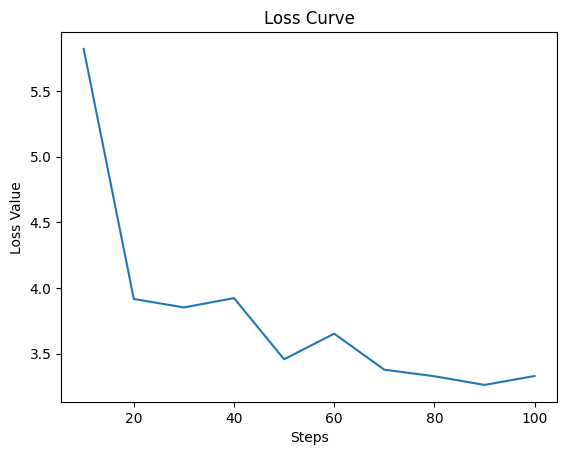

In [22]:
# filter out logs a loss value
logs = [entry for entry in trainer.state.log_history if 'loss' in entry]

# get the step number and loss value for each step in the filtered data
steps = [entry['step'] for entry in logs]
losses = [entry['loss'] for entry in logs]

plt.plot(steps, losses)
# plt.plot(steps_fast_learning, losses_fast_learning)
plt.title('Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.show()

In [ ]:
# save the trained model
trainer.save_model('name-gpt')
tokenizer.save_pretrained('name-gpt')

In [26]:
# generate new names
generator = pipeline(
    'text-generation',
    model='name-gpt',
    tokenizer=tokenizer,
)

generated_names = generator(
    'jim',
    max_length=20,
    truncation=True,
    do_sample=True,
    num_return_sequences=10,
    top_k=50,
    top_p=0.95,
    temperature=0.3
)

for name in generated_names:
    print(name['generated_text'])

ValueError: Unrecognized model in name-gpt. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, aria, aria_text, audio-spectrogram-transformer, autoformer, aya_vision, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, colpali, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deepseek_v3, deformable_detr, deit, depth_anything, depth_pro, deta, detr, diffllama, dinat, dinov2, dinov2_with_registers, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, emu3, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, falcon_mamba, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, gemma3, gemma3_text, git, glm, glm4, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, granite, granitemoe, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hiera, hubert, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llama4, llama4_text, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mimi, mistral, mistral3, mixtral, mllama, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, phi4_multimodal, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prompt_depth_anything, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_vl, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, qwen3, qwen3_moe, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, sam_vision_model, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, shieldgemma2, siglip, siglip2, siglip_vision_model, smolvlm, smolvlm_vision, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, textnet, time_series_transformer, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zamba, zamba2, zoedepth